# Meta Methods applied to the clickbait data set

### TFID preprocessing

In [ ]:
# Libraries
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import shuffle
from nltk.corpus import stopwords
from nltk.stem.snowball import EnglishStemmer
from nltk import word_tokenize
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets as ds
import sklearn.model_selection as cv
import sklearn.neighbors as nb
import pandas as pd
import nltk
import re
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

stemmer = EnglishStemmer(ignore_stopwords=True)
tokenize = TfidfVectorizer().build_tokenizer()


def stemmed_words(doc):
    return (stemmer.stem(w) for w in tokenize(doc))

# Function to get the tf_idf scores for a list of strings representing a title
# takes a list of strings as parameters
def pre_tfidf2(data):
    nr_pattern = re.compile(r'\b[+-]?\d*[.,]?\d+([eE][+-]?\d+)?\b')
    acronyms = re.compile(r'\b(\w)[.+:\-]')
    non_alphanum = re.compile(r'[^\w\d\-\+\s]')
    for i in range(len(data)):
        title = acronyms.sub(r'\1', data[i])
        title = non_alphanum.sub(' ', title)
        data[i] = nr_pattern.sub('NUMBER_SPECIAL_TOKEN', title)
    vectorizer = TfidfVectorizer(
        tokenizer=stemmed_words, stop_words=stopwords.words('english'), max_features=1000)
    X = vectorizer.fit_transform(data)
    # features = vectorizer.get_feature_names()
    return X.toarray()


# reading the data
dt_true = pd.read_csv('clickbait_data.txt', sep='\n', names=['Title'])
dt_false = pd.read_csv('non_clickbait_data.txt', sep='\n', names=['Title'])
dt_true = dt_true.assign(Label=lambda x: True)
dt_false = dt_false.assign(Label=lambda x: False)

# merging the data
dt = pd.concat([dt_true, dt_false], ignore_index=True)

# shulffing data
dt = shuffle(dt).reset_index(drop=True)

# computing tf-idf
X = pre_tfidf2(dt['Title'].to_list())  # tf_idf scores
y = dt['Label']  # labels



In [ ]:
dt.head()

,Title,Label
0,Advocates of Gun Rights Are Poised for a Victory,False
1,The Power of a Nudge Toward Thrift,False
2,Here's How You Can Actually Find The Best Loca...,True
3,Profit Decline at Nokia Comes With a Warning,False
4,The 17 Most Offensive Things People Say To Som...,True


## Voting scheme

In [ ]:
from sklearn.model_selection import cross_val_score
#from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

cv=10

clf1 = GaussianNB()

#params = {'n_neighbors':list(range(1,30,2)), 'weights':('distance','uniform')}
knc = KNeighborsClassifier()
#clf = GridSearchCV(knc, param_grid=params,cv=cv,n_jobs=-1)  # If cv is integer, by default is Stratifyed 
#clf.fit(X, y)
#print("Best Params fo Knn=",clf.best_params_, "Accuracy=", clf.best_score_)
#parval=clf.best_params_
parval={'n_neighbors': 9, 'weights': 'distance'}
clf2 = KNeighborsClassifier(n_neighbors=parval['n_neighbors'],weights=parval['weights'])

clf3 = DecisionTreeClassifier(criterion='entropy')


for clf, label in zip([clf1, clf2, clf3], ['Naive Bayes','Knn (3)', 'Dec. Tree', ]):
    scores = cross_val_score(clf, X, y, cv=cv, scoring='accuracy')
    print("Accuracy: %0.3f [%s]" % (scores.mean(), label))
    

Accuracy: 0.905 [Naive Bayes]
Accuracy: 0.849 [Knn (3)]
Accuracy: 0.873 [Dec. Tree]


In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

eclf = VotingClassifier(estimators=[('nb', clf1), ('knn3', clf2), ('dt', clf3)], voting='hard')
scores = cross_val_score(eclf, X, y, cv=cv, scoring='accuracy')
print("Accuracy: %0.3f [%s]" % (scores.mean() , "Majority Voting"))


Accuracy: 0.913 [Majority Voting]


In [ ]:
eclf = VotingClassifier(estimators=[('nb', clf1), ('knn3', clf2), ('dt', clf3)],voting='soft', weights=[2,1,2])
scores = cross_val_score(eclf, X, y, cv=cv, scoring='accuracy')
print("Accuracy: %0.3f [%s]" % (scores.mean(), "Weighted Voting"))

Accuracy: 0.914 [Weighted Voting]


## Bagging

In [ ]:
from sklearn.ensemble import BaggingClassifier

lb=[]
for nest in [1,2,5,10,20,50,100,200]:
    scores = cross_val_score(BaggingClassifier(base_estimator=DecisionTreeClassifier(),n_estimators=nest), X, y, cv=cv, scoring='accuracy')
    print("Accuracy: %0.3f [%s]" % (scores.mean(), nest))
    lb.append(scores.mean())

lb2=[]    
print()
for nest in [1,2,5,10,20,50,100,200]:
    scores = cross_val_score(BaggingClassifier(base_estimator=DecisionTreeClassifier(),n_estimators=nest,max_features=0.35), X, y, cv=cv, scoring='accuracy')
    print("Accuracy: %0.3f [%s]" % (scores.mean(), nest))
    lb2.append(scores.mean())

Accuracy: 0.866 [1]
Accuracy: 0.873 [2]
Accuracy: 0.882 [5]
Accuracy: 0.887 [10]
Accuracy: 0.888 [20]
Accuracy: 0.889 [50]
Accuracy: 0.891 [100]
Accuracy: 0.891 [200]

Accuracy: 0.753 [1]
Accuracy: 0.804 [2]
Accuracy: 0.864 [5]
Accuracy: 0.893 [10]
Accuracy: 0.901 [20]
Accuracy: 0.913 [50]
Accuracy: 0.915 [100]
Accuracy: 0.918 [200]


## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

lrf=[]
for nest in [1,2,5,10,20,50,100,200]:
    scores = cross_val_score(RandomForestClassifier(n_estimators=nest), X, y, cv=cv, scoring='accuracy')
    print("Accuracy: %0.3f [%s]" % (scores.mean(), nest))
    lrf.append(scores.mean())

Accuracy: 0.860 [1]
Accuracy: 0.865 [2]
Accuracy: 0.893 [5]
Accuracy: 0.898 [10]
Accuracy: 0.902 [20]
Accuracy: 0.902 [50]
Accuracy: 0.902 [100]
Accuracy: 0.902 [200]


In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

lext=[]
for nest in [1,2,5,10,20,50,100,200]:
    scores = cross_val_score(ExtraTreesClassifier(n_estimators=nest), X, y, cv=cv, scoring='accuracy')
    print("Accuracy: %0.3f [%s]" % (scores.mean(), nest))
    lext.append(scores.mean())

Accuracy: 0.873 [1]
Accuracy: 0.876 [2]
Accuracy: 0.901 [5]
Accuracy: 0.907 [10]
Accuracy: 0.908 [20]
Accuracy: 0.910 [50]
Accuracy: 0.911 [100]
Accuracy: 0.911 [200]


## Boosting

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

lboo=[]
for nest in [1,2,5,10,20,50,100,200]:
    scores = cross_val_score(AdaBoostClassifier(n_estimators=nest), X, y, cv=cv, scoring='accuracy')
    print("Accuracy: %0.3f [%s]" % (scores.mean(), nest))
    lboo.append(scores.mean())

Accuracy: 0.632 [1]
Accuracy: 0.641 [2]
Accuracy: 0.668 [5]
Accuracy: 0.707 [10]
Accuracy: 0.750 [20]
Accuracy: 0.808 [50]
Accuracy: 0.846 [100]
Accuracy: 0.880 [200]


In [ ]:
from sklearn.ensemble import AdaBoostClassifier

lboodt=[]
for nest in [1,2,5,10,20,50,100,200]:
    scores = cross_val_score(AdaBoostClassifier(DecisionTreeClassifier(max_depth=5),n_estimators=nest), X, y, cv=cv, scoring='accuracy')
    print("Accuracy: %0.3f [%s]" % (scores.mean(), nest))
    lboodt.append(scores.mean())

Accuracy: 0.700 [1]
Accuracy: 0.731 [2]
Accuracy: 0.776 [5]
Accuracy: 0.812 [10]
Accuracy: 0.846 [20]
Accuracy: 0.887 [50]
Accuracy: 0.905 [100]
Accuracy: 0.904 [200]


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

lgbboo=[]
for nest in [1,2,5,10,20,50,100,200]:
    scores = cross_val_score(GradientBoostingClassifier(n_estimators=nest), X, y, cv=cv, scoring='accuracy')
    print("Accuracy: %0.3f [%s]" % (scores.mean(), nest))
    lgbboo.append(scores.mean())

Accuracy: 0.674 [1]
Accuracy: 0.684 [2]
Accuracy: 0.702 [5]
Accuracy: 0.719 [10]
Accuracy: 0.733 [20]
Accuracy: 0.768 [50]
Accuracy: 0.808 [100]
Accuracy: 0.839 [200]


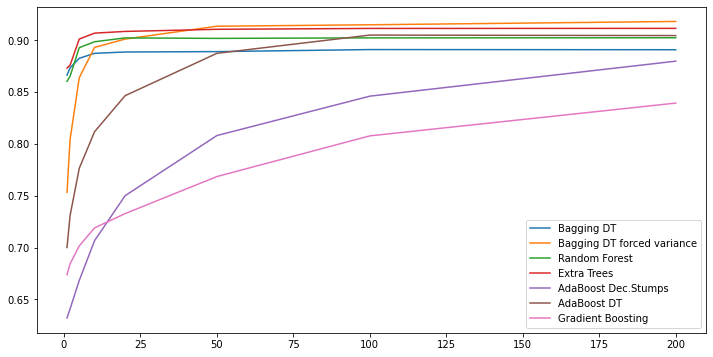

In [ ]:
import  matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot([1,2,5,10,20,50,100,200],lb,label="Bagging DT")
plt.plot([1,2,5,10,20,50,100,200],lb2,label="Bagging DT forced variance")
plt.plot([1,2,5,10,20,50,100,200],lrf,label="Random Forest")
plt.plot([1,2,5,10,20,50,100,200],lext,label="Extra Trees")
plt.plot([1,2,5,10,20,50,100,200],lboo,label="AdaBoost Dec.Stumps")
plt.plot([1,2,5,10,20,50,100,200],lboodt,label="AdaBoost DT")
plt.plot([1,2,5,10,20,50,100,200],lgbboo,label="Gradient Boosting")
plt.legend(loc='lower right')

plt.show()

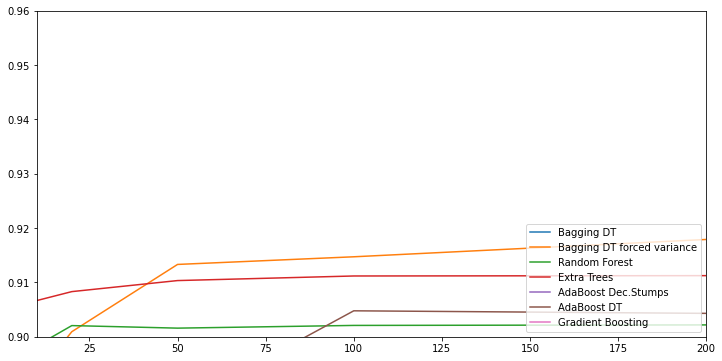

In [ ]:
plt.figure(figsize=(12,6))
plt.plot([1,2,5,10,20,50,100,200],lb,label="Bagging DT")
plt.plot([1,2,5,10,20,50,100,200],lb2,label="Bagging DT forced variance")
plt.plot([1,2,5,10,20,50,100,200],lrf,label="Random Forest")
plt.plot([1,2,5,10,20,50,100,200],lext,label="Extra Trees")
plt.plot([1,2,5,10,20,50,100,200],lboo,label="AdaBoost Dec.Stumps")
plt.plot([1,2,5,10,20,50,100,200],lboodt,label="AdaBoost DT")
plt.plot([1,2,5,10,20,50,100,200],lgbboo,label="Gradient Boosting")
plt.legend(loc='lower right')
plt.xlim(10,200)
plt.ylim(0.90,0.96)
plt.show()

## Feature Selection with Forests of trees

In [ ]:
clf = RandomForestClassifier(n_estimators=100)
clf = clf.fit(X, y)
print(clf.feature_importances_)  


[4.17662861e-05 1.13900925e-03 7.14100413e-04 1.52976994e-04
 2.21094504e-04 1.02406088e-03 3.19355110e-04 4.54516214e-04
 6.41188122e-05 1.89261569e-04 7.17417706e-05 6.03982005e-04
 1.50798910e-02 4.92651075e-04 2.78733845e-04 2.21965909e-03
 1.69276310e-04 3.49162258e-03 3.81402692e-04 4.28468213e-04
 1.56954565e-03 2.18962225e-04 4.35197445e-04 1.82124679e-04
 7.14439278e-05 3.84764002e-03 2.04640497e-04 1.05332148e-03
 1.04140577e-03 3.12818939e-04 2.49299295e-04 1.12021557e-04
 7.39108150e-04 2.47860692e-04 2.12788964e-04 2.16878354e-04
 2.04488229e-03 4.59996228e-04 1.23517895e-03 6.36477145e-04
 1.50483838e-04 1.64097281e-03 1.05237040e-03 3.64960320e-04
 2.87553455e-04 1.20064744e-04 4.17176594e-04 2.37554144e-03
 1.60341778e-04 2.30488162e-04 5.04035050e-04 2.12283226e-04
 1.16895383e-04 1.30505432e-04 5.40015579e-04 2.44515511e-03
 3.65191848e-04 9.98604914e-04 5.63245011e-04 9.81018425e-04
 1.54609966e-04 7.69355627e-04 3.44154682e-03 2.10574944e-04
 9.68039965e-04 7.701983

In [ ]:
from sklearn.feature_selection import SelectFromModel

model = SelectFromModel(clf, prefit=True, threshold=0.05)
X_new = model.transform(X)
print(X_new.shape)

print(np.mean(cross_val_score(KNeighborsClassifier(), X=X, y=y, cv=cv, scoring='accuracy')))
print(np.mean(cross_val_score(KNeighborsClassifier(), X=X_new, y=y, cv=cv, scoring='accuracy')))

(32000, 1)
0.85584375
0.48934375


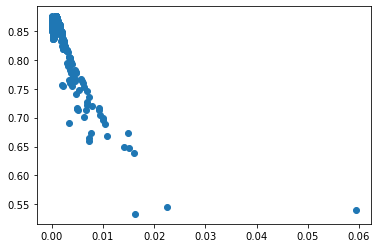

Best threshold:  0.0008484002403463266


In [ ]:
thresholds=clf.feature_importances_

l=[]
lparval=[]
for threshold in thresholds:
    model = SelectFromModel(clf, prefit=True, threshold=threshold)
    X_new = model.transform(X)
    #params = {'n_neighbors':list(range(1,30,2)), 'weights':('distance','uniform')}
    #knc = KNeighborsClassifier()
    #clf2 = GridSearchCV(knc, param_grid=params,cv=cv,n_jobs=-1)  # If cv is integer, by default is Stratifyed 
    #clf2.fit(X, y)
    parval={'n_neighbors':9, 'weights':'distance'}
    clf3 = KNeighborsClassifier(n_neighbors=parval['n_neighbors'],weights=parval['weights'])
    acc = np.mean(cross_val_score(clf3, X=X_new, y=y, cv=cv, scoring='accuracy'))
    l.append(acc)
    lparval.append(parval)
    
plt.scatter(thresholds,l)
plt.show()

print('Best threshold: ',thresholds[np.argmax(l)])

In [ ]:
parval=lparval[np.argmax(l)]
model = SelectFromModel(clf, prefit=True, threshold=thresholds[np.argmax(l)])
X_new = model.transform(X)
print(X_new.shape)

print('Original: ', np.mean(cross_val_score(KNeighborsClassifier(n_neighbors=1), X=X, y=y, cv=cv, scoring='accuracy')))
print('With FS: ', np.mean(cross_val_score(KNeighborsClassifier(n_neighbors=parval['n_neighbors'],weights=parval['weights']), X=X_new, y=y, cv=cv, scoring='accuracy')))

(32000, 252)
Original:  0.8584375
With FS:  0.875375
